In [22]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
13017,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
13018,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
13019,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
13020,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
13021,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 13022/13022 [00:47<00:00, 273.85it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(13022, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
5504,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5505,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5506,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5507,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5508,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 5509/5509 [00:31<00:00, 172.19it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(5509, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    13022
class       51
dtype: int64
image    5509
class      51
dtype: int64


In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(13022, 51)
(5509, 51)


In [10]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [11]:
print(base_model.output_shape)

(None, None, None, 2048)


In [12]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

In [13]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

In [14]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

2020-03-17 13:57:34.062969
(13022, 7, 7, 2048)
2020-03-17 16:14:19.003689


In [17]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

2020-03-17 17:58:32.482920
(5509, 7, 7, 2048)
2020-03-17 17:58:32.487930


In [18]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(13022, 7*7*2048)
X_test = X_test.reshape(5509, 7*7*2048)

In [19]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [23]:
# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train.pkl') 
joblib.dump(X_test, '../Pickle/ResNet101V2_X_test.pkl')

['../Pickle/ResNet101V2_X_test.pkl']

In [24]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test.pkl') 

In [25]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13022, 100352)
(5509, 100352)
(13022, 51)
(5509, 51)


In [26]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [27]:
model.output_shape

(None, 51)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [29]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 100352),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_init

In [30]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [31]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [32]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-03-17 18:03:56.974931
Train on 13022 samples, validate on 5509 samples
Epoch 1/100
13022/13022 [==============================] - ETA: 6:47 - loss: 3.9319 - accuracy: 0.03 - ETA: 4:43 - loss: 3.9338 - accuracy: 0.02 - ETA: 3:49 - loss: 3.9326 - accuracy: 0.02 - ETA: 3:25 - loss: 3.9320 - accuracy: 0.02 - ETA: 3:14 - loss: 3.9326 - accuracy: 0.02 - ETA: 3:08 - loss: 3.9249 - accuracy: 0.02 - ETA: 3:03 - loss: 3.9314 - accuracy: 0.02 - ETA: 2:59 - loss: 3.9255 - accuracy: 0.03 - ETA: 2:56 - loss: 3.9266 - accuracy: 0.03 - ETA: 2:52 - loss: 3.9258 - accuracy: 0.03 - ETA: 2:48 - loss: 3.9207 - accuracy: 0.03 - ETA: 2:43 - loss: 3.9201 - accuracy: 0.03 - ETA: 2:41 - loss: 3.9201 - accuracy: 0.03 - ETA: 2:38 - loss: 3.9213 - accuracy: 0.03 - ETA: 2:36 - loss: 3.9203 - accuracy: 0.03 - ETA: 2:34 - loss: 3.9191 - accuracy: 0.03 - ETA: 2:32 - loss: 3.9180 - accuracy: 0.03 - ETA: 2:30 - loss: 3.9150 - accuracy: 0.03 - ETA: 2:28 - loss: 3.9113 - accuracy: 0.03 - ETA: 2:26 - loss: 3.9063 - ac

13022/13022 [==============================] - ETA: 3:16 - loss: 2.5110 - accuracy: 0.33 - ETA: 3:04 - loss: 2.2323 - accuracy: 0.41 - ETA: 2:59 - loss: 2.1896 - accuracy: 0.42 - ETA: 2:56 - loss: 2.1427 - accuracy: 0.43 - ETA: 2:53 - loss: 2.1466 - accuracy: 0.42 - ETA: 2:51 - loss: 2.1335 - accuracy: 0.42 - ETA: 2:49 - loss: 2.1075 - accuracy: 0.43 - ETA: 2:48 - loss: 2.1139 - accuracy: 0.43 - ETA: 2:45 - loss: 2.0867 - accuracy: 0.44 - ETA: 2:43 - loss: 2.0650 - accuracy: 0.44 - ETA: 2:41 - loss: 2.0623 - accuracy: 0.44 - ETA: 2:39 - loss: 2.0680 - accuracy: 0.44 - ETA: 2:37 - loss: 2.0606 - accuracy: 0.44 - ETA: 2:35 - loss: 2.0481 - accuracy: 0.45 - ETA: 2:33 - loss: 2.0358 - accuracy: 0.45 - ETA: 2:32 - loss: 2.0426 - accuracy: 0.45 - ETA: 2:30 - loss: 2.0376 - accuracy: 0.45 - ETA: 2:29 - loss: 2.0228 - accuracy: 0.45 - ETA: 2:26 - loss: 2.0333 - accuracy: 0.45 - ETA: 2:24 - loss: 2.0188 - accuracy: 0.45 - ETA: 2:23 - loss: 2.0042 - accuracy: 0.45 - ETA: 2:21 - loss: 1.9991 - ac

13022/13022 [==============================] - ETA: 3:09 - loss: 1.2204 - accuracy: 0.60 - ETA: 2:58 - loss: 1.2264 - accuracy: 0.60 - ETA: 2:55 - loss: 1.1652 - accuracy: 0.64 - ETA: 2:51 - loss: 1.1407 - accuracy: 0.65 - ETA: 2:50 - loss: 1.1004 - accuracy: 0.66 - ETA: 2:48 - loss: 1.1504 - accuracy: 0.65 - ETA: 2:47 - loss: 1.1418 - accuracy: 0.65 - ETA: 2:45 - loss: 1.1074 - accuracy: 0.66 - ETA: 2:43 - loss: 1.1143 - accuracy: 0.67 - ETA: 2:40 - loss: 1.1284 - accuracy: 0.67 - ETA: 2:38 - loss: 1.1243 - accuracy: 0.67 - ETA: 2:36 - loss: 1.1195 - accuracy: 0.67 - ETA: 2:34 - loss: 1.1370 - accuracy: 0.66 - ETA: 2:33 - loss: 1.1404 - accuracy: 0.66 - ETA: 2:32 - loss: 1.1261 - accuracy: 0.67 - ETA: 2:30 - loss: 1.1269 - accuracy: 0.66 - ETA: 2:28 - loss: 1.1153 - accuracy: 0.67 - ETA: 2:27 - loss: 1.1093 - accuracy: 0.67 - ETA: 2:25 - loss: 1.1101 - accuracy: 0.67 - ETA: 2:23 - loss: 1.1038 - accuracy: 0.67 - ETA: 2:22 - loss: 1.0987 - accuracy: 0.67 - ETA: 2:20 - loss: 1.0960 - ac

13022/13022 [==============================] - ETA: 3:02 - loss: 0.7503 - accuracy: 0.75 - ETA: 2:56 - loss: 0.6911 - accuracy: 0.76 - ETA: 2:52 - loss: 0.7367 - accuracy: 0.76 - ETA: 2:49 - loss: 0.7524 - accuracy: 0.76 - ETA: 2:49 - loss: 0.7708 - accuracy: 0.76 - ETA: 2:47 - loss: 0.7489 - accuracy: 0.76 - ETA: 2:44 - loss: 0.7244 - accuracy: 0.77 - ETA: 2:43 - loss: 0.7175 - accuracy: 0.78 - ETA: 2:41 - loss: 0.7299 - accuracy: 0.77 - ETA: 2:39 - loss: 0.7390 - accuracy: 0.77 - ETA: 2:38 - loss: 0.7346 - accuracy: 0.77 - ETA: 2:36 - loss: 0.7277 - accuracy: 0.77 - ETA: 2:34 - loss: 0.7142 - accuracy: 0.78 - ETA: 2:32 - loss: 0.7150 - accuracy: 0.78 - ETA: 2:31 - loss: 0.7133 - accuracy: 0.77 - ETA: 2:29 - loss: 0.7176 - accuracy: 0.77 - ETA: 2:28 - loss: 0.7142 - accuracy: 0.77 - ETA: 2:27 - loss: 0.7112 - accuracy: 0.77 - ETA: 2:25 - loss: 0.7117 - accuracy: 0.77 - ETA: 2:23 - loss: 0.7157 - accuracy: 0.77 - ETA: 2:21 - loss: 0.7113 - accuracy: 0.77 - ETA: 2:19 - loss: 0.7073 - ac

13022/13022 [==============================] - ETA: 2:58 - loss: 0.4383 - accuracy: 0.86 - ETA: 2:54 - loss: 0.5205 - accuracy: 0.83 - ETA: 2:52 - loss: 0.4585 - accuracy: 0.85 - ETA: 2:50 - loss: 0.4910 - accuracy: 0.84 - ETA: 2:48 - loss: 0.5079 - accuracy: 0.84 - ETA: 2:46 - loss: 0.5177 - accuracy: 0.84 - ETA: 2:44 - loss: 0.5070 - accuracy: 0.84 - ETA: 2:43 - loss: 0.5012 - accuracy: 0.84 - ETA: 2:41 - loss: 0.5044 - accuracy: 0.84 - ETA: 2:39 - loss: 0.5032 - accuracy: 0.84 - ETA: 2:38 - loss: 0.5016 - accuracy: 0.84 - ETA: 2:36 - loss: 0.4965 - accuracy: 0.84 - ETA: 2:34 - loss: 0.5096 - accuracy: 0.84 - ETA: 2:33 - loss: 0.5141 - accuracy: 0.84 - ETA: 2:31 - loss: 0.5172 - accuracy: 0.84 - ETA: 2:29 - loss: 0.5071 - accuracy: 0.84 - ETA: 2:27 - loss: 0.5090 - accuracy: 0.84 - ETA: 2:26 - loss: 0.5116 - accuracy: 0.84 - ETA: 2:24 - loss: 0.5071 - accuracy: 0.84 - ETA: 2:22 - loss: 0.5117 - accuracy: 0.84 - ETA: 2:20 - loss: 0.5207 - accuracy: 0.84 - ETA: 2:18 - loss: 0.5206 - ac

13022/13022 [==============================] - ETA: 2:49 - loss: 0.3013 - accuracy: 0.91 - ETA: 2:48 - loss: 0.3799 - accuracy: 0.88 - ETA: 2:47 - loss: 0.3984 - accuracy: 0.87 - ETA: 2:46 - loss: 0.3611 - accuracy: 0.88 - ETA: 2:45 - loss: 0.3654 - accuracy: 0.88 - ETA: 2:43 - loss: 0.3479 - accuracy: 0.88 - ETA: 2:41 - loss: 0.3616 - accuracy: 0.88 - ETA: 2:39 - loss: 0.3630 - accuracy: 0.88 - ETA: 2:38 - loss: 0.3737 - accuracy: 0.88 - ETA: 2:37 - loss: 0.3688 - accuracy: 0.88 - ETA: 2:35 - loss: 0.3722 - accuracy: 0.88 - ETA: 2:34 - loss: 0.3771 - accuracy: 0.88 - ETA: 2:32 - loss: 0.3771 - accuracy: 0.88 - ETA: 2:30 - loss: 0.3835 - accuracy: 0.87 - ETA: 2:28 - loss: 0.3813 - accuracy: 0.87 - ETA: 2:26 - loss: 0.3736 - accuracy: 0.87 - ETA: 2:24 - loss: 0.3786 - accuracy: 0.87 - ETA: 2:23 - loss: 0.3737 - accuracy: 0.87 - ETA: 2:21 - loss: 0.3743 - accuracy: 0.87 - ETA: 2:20 - loss: 0.3673 - accuracy: 0.88 - ETA: 2:19 - loss: 0.3640 - accuracy: 0.88 - ETA: 2:18 - loss: 0.3596 - ac

13022/13022 [==============================] - ETA: 2:45 - loss: 0.2994 - accuracy: 0.90 - ETA: 2:49 - loss: 0.3632 - accuracy: 0.89 - ETA: 2:49 - loss: 0.3628 - accuracy: 0.90 - ETA: 2:46 - loss: 0.3418 - accuracy: 0.90 - ETA: 2:44 - loss: 0.3348 - accuracy: 0.90 - ETA: 2:43 - loss: 0.3322 - accuracy: 0.90 - ETA: 2:42 - loss: 0.3255 - accuracy: 0.90 - ETA: 2:40 - loss: 0.3311 - accuracy: 0.90 - ETA: 2:38 - loss: 0.3246 - accuracy: 0.90 - ETA: 2:36 - loss: 0.3044 - accuracy: 0.90 - ETA: 2:34 - loss: 0.3041 - accuracy: 0.90 - ETA: 2:33 - loss: 0.3048 - accuracy: 0.90 - ETA: 2:32 - loss: 0.2967 - accuracy: 0.91 - ETA: 2:29 - loss: 0.2949 - accuracy: 0.91 - ETA: 2:28 - loss: 0.2888 - accuracy: 0.91 - ETA: 2:26 - loss: 0.2950 - accuracy: 0.90 - ETA: 2:25 - loss: 0.2952 - accuracy: 0.91 - ETA: 2:23 - loss: 0.2929 - accuracy: 0.91 - ETA: 2:21 - loss: 0.2915 - accuracy: 0.91 - ETA: 2:20 - loss: 0.2913 - accuracy: 0.91 - ETA: 2:18 - loss: 0.2933 - accuracy: 0.91 - ETA: 2:16 - loss: 0.2898 - ac

13022/13022 [==============================] - ETA: 2:46 - loss: 0.2240 - accuracy: 0.95 - ETA: 2:48 - loss: 0.1732 - accuracy: 0.96 - ETA: 2:46 - loss: 0.1640 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1533 - accuracy: 0.95 - ETA: 2:46 - loss: 0.1688 - accuracy: 0.95 - ETA: 2:45 - loss: 0.1736 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1750 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1948 - accuracy: 0.94 - ETA: 2:39 - loss: 0.1973 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1937 - accuracy: 0.94 - ETA: 2:36 - loss: 0.2015 - accuracy: 0.94 - ETA: 2:34 - loss: 0.2047 - accuracy: 0.94 - ETA: 2:32 - loss: 0.2041 - accuracy: 0.94 - ETA: 2:30 - loss: 0.2028 - accuracy: 0.94 - ETA: 2:28 - loss: 0.2053 - accuracy: 0.94 - ETA: 2:27 - loss: 0.2018 - accuracy: 0.94 - ETA: 2:24 - loss: 0.1974 - accuracy: 0.94 - ETA: 2:23 - loss: 0.1943 - accuracy: 0.94 - ETA: 2:22 - loss: 0.1950 - accuracy: 0.94 - ETA: 2:21 - loss: 0.1969 - accuracy: 0.94 - ETA: 2:19 - loss: 0.2006 - accuracy: 0.94 - ETA: 2:17 - loss: 0.1963 - ac

13022/13022 [==============================] - ETA: 2:44 - loss: 0.1038 - accuracy: 0.96 - ETA: 2:47 - loss: 0.1704 - accuracy: 0.94 - ETA: 2:47 - loss: 0.1666 - accuracy: 0.95 - ETA: 2:46 - loss: 0.1751 - accuracy: 0.94 - ETA: 2:43 - loss: 0.1594 - accuracy: 0.94 - ETA: 2:41 - loss: 0.1986 - accuracy: 0.93 - ETA: 2:39 - loss: 0.2010 - accuracy: 0.94 - ETA: 2:37 - loss: 0.2057 - accuracy: 0.94 - ETA: 2:35 - loss: 0.1972 - accuracy: 0.94 - ETA: 2:33 - loss: 0.1915 - accuracy: 0.94 - ETA: 2:32 - loss: 0.1825 - accuracy: 0.94 - ETA: 2:30 - loss: 0.1796 - accuracy: 0.94 - ETA: 2:29 - loss: 0.1712 - accuracy: 0.95 - ETA: 2:28 - loss: 0.1688 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1713 - accuracy: 0.95 - ETA: 2:24 - loss: 0.1703 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1657 - accuracy: 0.95 - ETA: 2:20 - loss: 0.1615 - accuracy: 0.95 - ETA: 2:19 - loss: 0.1644 - accuracy: 0.95 - ETA: 2:18 - loss: 0.1637 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1633 - accuracy: 0.95 - ETA: 2:15 - loss: 0.1650 - ac

13022/13022 [==============================] - ETA: 2:49 - loss: 0.1012 - accuracy: 0.97 - ETA: 2:50 - loss: 0.2606 - accuracy: 0.94 - ETA: 2:45 - loss: 0.2234 - accuracy: 0.95 - ETA: 2:43 - loss: 0.2321 - accuracy: 0.94 - ETA: 2:45 - loss: 0.2089 - accuracy: 0.95 - ETA: 2:43 - loss: 0.2103 - accuracy: 0.94 - ETA: 2:40 - loss: 0.2007 - accuracy: 0.94 - ETA: 2:38 - loss: 0.1983 - accuracy: 0.94 - ETA: 2:37 - loss: 0.1891 - accuracy: 0.94 - ETA: 2:34 - loss: 0.1860 - accuracy: 0.94 - ETA: 2:32 - loss: 0.1853 - accuracy: 0.94 - ETA: 2:30 - loss: 0.1772 - accuracy: 0.95 - ETA: 2:29 - loss: 0.1788 - accuracy: 0.95 - ETA: 2:28 - loss: 0.1751 - accuracy: 0.95 - ETA: 2:26 - loss: 0.1690 - accuracy: 0.95 - ETA: 2:24 - loss: 0.1637 - accuracy: 0.95 - ETA: 2:22 - loss: 0.1616 - accuracy: 0.95 - ETA: 2:21 - loss: 0.1755 - accuracy: 0.95 - ETA: 2:20 - loss: 0.1729 - accuracy: 0.95 - ETA: 2:19 - loss: 0.1717 - accuracy: 0.95 - ETA: 2:17 - loss: 0.1821 - accuracy: 0.95 - ETA: 2:16 - loss: 0.1791 - ac

13022/13022 [==============================] - ETA: 2:43 - loss: 0.1379 - accuracy: 0.96 - ETA: 2:44 - loss: 0.1414 - accuracy: 0.95 - ETA: 2:43 - loss: 0.1571 - accuracy: 0.95 - ETA: 2:41 - loss: 0.1407 - accuracy: 0.96 - ETA: 2:39 - loss: 0.1355 - accuracy: 0.95 - ETA: 2:37 - loss: 0.1395 - accuracy: 0.96 - ETA: 2:36 - loss: 0.1257 - accuracy: 0.96 - ETA: 2:35 - loss: 0.1216 - accuracy: 0.97 - ETA: 2:33 - loss: 0.1218 - accuracy: 0.97 - ETA: 2:33 - loss: 0.1220 - accuracy: 0.97 - ETA: 2:31 - loss: 0.1189 - accuracy: 0.97 - ETA: 2:29 - loss: 0.1245 - accuracy: 0.96 - ETA: 2:27 - loss: 0.1195 - accuracy: 0.97 - ETA: 2:25 - loss: 0.1138 - accuracy: 0.97 - ETA: 2:24 - loss: 0.1128 - accuracy: 0.97 - ETA: 2:23 - loss: 0.1210 - accuracy: 0.96 - ETA: 2:22 - loss: 0.1210 - accuracy: 0.96 - ETA: 2:21 - loss: 0.1215 - accuracy: 0.96 - ETA: 2:20 - loss: 0.1210 - accuracy: 0.96 - ETA: 2:18 - loss: 0.1215 - accuracy: 0.96 - ETA: 2:16 - loss: 0.1184 - accuracy: 0.96 - ETA: 2:14 - loss: 0.1177 - ac

13022/13022 [==============================] - ETA: 3:13 - loss: 0.1083 - accuracy: 0.96 - ETA: 3:14 - loss: 0.1174 - accuracy: 0.97 - ETA: 3:13 - loss: 0.1116 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1278 - accuracy: 0.95 - ETA: 3:13 - loss: 0.1393 - accuracy: 0.95 - ETA: 3:17 - loss: 0.1489 - accuracy: 0.95 - ETA: 3:18 - loss: 0.1509 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1430 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1443 - accuracy: 0.95 - ETA: 3:11 - loss: 0.1377 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1370 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1365 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1368 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1459 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1469 - accuracy: 0.95 - ETA: 2:55 - loss: 0.1504 - accuracy: 0.95 - ETA: 2:53 - loss: 0.1459 - accuracy: 0.95 - ETA: 2:50 - loss: 0.1516 - accuracy: 0.95 - ETA: 2:48 - loss: 0.1540 - accuracy: 0.96 - ETA: 2:46 - loss: 0.1519 - accuracy: 0.96 - ETA: 2:43 - loss: 0.1511 - accuracy: 0.96 - ETA: 2:41 - loss: 0.1502 - ac

13022/13022 [==============================] - ETA: 2:55 - loss: 0.0483 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0648 - accuracy: 0.97 - ETA: 2:51 - loss: 0.0776 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0676 - accuracy: 0.98 - ETA: 2:46 - loss: 0.0666 - accuracy: 0.98 - ETA: 2:43 - loss: 0.0797 - accuracy: 0.97 - ETA: 2:43 - loss: 0.0758 - accuracy: 0.97 - ETA: 2:41 - loss: 0.0726 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0903 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0848 - accuracy: 0.97 - ETA: 2:36 - loss: 0.0896 - accuracy: 0.97 - ETA: 2:33 - loss: 0.0904 - accuracy: 0.97 - ETA: 2:32 - loss: 0.0912 - accuracy: 0.97 - ETA: 2:30 - loss: 0.0981 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0944 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0950 - accuracy: 0.97 - ETA: 2:25 - loss: 0.1046 - accuracy: 0.97 - ETA: 2:23 - loss: 0.1046 - accuracy: 0.97 - ETA: 2:21 - loss: 0.1018 - accuracy: 0.97 - ETA: 2:19 - loss: 0.1028 - accuracy: 0.97 - ETA: 2:18 - loss: 0.1010 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0980 - ac

13022/13022 [==============================] - ETA: 2:46 - loss: 0.0853 - accuracy: 0.98 - ETA: 2:44 - loss: 0.0704 - accuracy: 0.98 - ETA: 2:47 - loss: 0.0630 - accuracy: 0.98 - ETA: 2:46 - loss: 0.0633 - accuracy: 0.98 - ETA: 2:42 - loss: 0.0652 - accuracy: 0.98 - ETA: 2:40 - loss: 0.0658 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0617 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0733 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0734 - accuracy: 0.98 - ETA: 2:35 - loss: 0.0944 - accuracy: 0.97 - ETA: 2:33 - loss: 0.0891 - accuracy: 0.97 - ETA: 2:32 - loss: 0.0899 - accuracy: 0.97 - ETA: 2:30 - loss: 0.0917 - accuracy: 0.97 - ETA: 2:29 - loss: 0.0921 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0990 - accuracy: 0.97 - ETA: 2:25 - loss: 0.1041 - accuracy: 0.97 - ETA: 2:24 - loss: 0.1009 - accuracy: 0.97 - ETA: 2:22 - loss: 0.0981 - accuracy: 0.97 - ETA: 2:20 - loss: 0.0953 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0990 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0985 - accuracy: 0.97 - ETA: 2:15 - loss: 0.0972 - ac

13022/13022 [==============================] - ETA: 2:52 - loss: 0.0913 - accuracy: 0.97 - ETA: 2:52 - loss: 0.0707 - accuracy: 0.98 - ETA: 2:53 - loss: 0.0695 - accuracy: 0.98 - ETA: 2:48 - loss: 0.0724 - accuracy: 0.97 - ETA: 2:46 - loss: 0.0732 - accuracy: 0.97 - ETA: 2:44 - loss: 0.0681 - accuracy: 0.98 - ETA: 2:42 - loss: 0.0700 - accuracy: 0.98 - ETA: 2:41 - loss: 0.0818 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0814 - accuracy: 0.97 - ETA: 2:38 - loss: 0.1019 - accuracy: 0.97 - ETA: 2:36 - loss: 0.1135 - accuracy: 0.97 - ETA: 2:34 - loss: 0.1243 - accuracy: 0.96 - ETA: 2:32 - loss: 0.1185 - accuracy: 0.97 - ETA: 2:30 - loss: 0.1148 - accuracy: 0.97 - ETA: 2:28 - loss: 0.1121 - accuracy: 0.97 - ETA: 2:26 - loss: 0.1115 - accuracy: 0.97 - ETA: 2:24 - loss: 0.1115 - accuracy: 0.97 - ETA: 2:23 - loss: 0.1090 - accuracy: 0.97 - ETA: 2:21 - loss: 0.1046 - accuracy: 0.97 - ETA: 2:19 - loss: 0.1012 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0983 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0961 - ac

13022/13022 [==============================] - ETA: 2:48 - loss: 0.0487 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0491 - accuracy: 0.98 - ETA: 2:50 - loss: 0.0873 - accuracy: 0.97 - ETA: 2:49 - loss: 0.0782 - accuracy: 0.97 - ETA: 2:48 - loss: 0.0757 - accuracy: 0.97 - ETA: 2:47 - loss: 0.0696 - accuracy: 0.97 - ETA: 2:45 - loss: 0.0668 - accuracy: 0.97 - ETA: 2:43 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:42 - loss: 0.0777 - accuracy: 0.97 - ETA: 2:39 - loss: 0.0785 - accuracy: 0.97 - ETA: 2:37 - loss: 0.0760 - accuracy: 0.97 - ETA: 2:35 - loss: 0.0757 - accuracy: 0.97 - ETA: 2:33 - loss: 0.0808 - accuracy: 0.97 - ETA: 2:31 - loss: 0.0840 - accuracy: 0.97 - ETA: 2:29 - loss: 0.0839 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0863 - accuracy: 0.97 - ETA: 2:25 - loss: 0.0848 - accuracy: 0.97 - ETA: 2:23 - loss: 0.0843 - accuracy: 0.97 - ETA: 2:21 - loss: 0.0880 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0854 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0836 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0830 - ac

13022/13022 [==============================] - ETA: 1:53 - loss: 0.0817 - accuracy: 0.96 - ETA: 1:51 - loss: 0.0487 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0605 - accuracy: 0.97 - ETA: 1:47 - loss: 0.0632 - accuracy: 0.97 - ETA: 1:46 - loss: 0.0551 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0586 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0610 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0611 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0603 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0597 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0597 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0622 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0701 - accuracy: 0.97 - ETA: 1:37 - loss: 0.0690 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0681 - accuracy: 0.97 - ETA: 1:35 - loss: 0.0694 - accuracy: 0.97 - ETA: 1:33 - loss: 0.0670 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0703 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0722 - accuracy: 0.97 - ETA: 1:31 - loss: 0.0763 - accuracy: 0.97 - ETA: 1:30 - loss: 0.0758 - accuracy: 0.97 - ETA: 1:29 - loss: 0.0752 - ac

13022/13022 [==============================] - ETA: 1:54 - loss: 0.0479 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0765 - accuracy: 0.97 - ETA: 1:50 - loss: 0.0712 - accuracy: 0.97 - ETA: 1:49 - loss: 0.0565 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0736 - accuracy: 0.97 - ETA: 1:50 - loss: 0.0710 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0701 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0684 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0840 - accuracy: 0.97 - ETA: 1:44 - loss: 0.0882 - accuracy: 0.97 - ETA: 1:43 - loss: 0.1165 - accuracy: 0.97 - ETA: 1:41 - loss: 0.1166 - accuracy: 0.97 - ETA: 1:40 - loss: 0.1150 - accuracy: 0.97 - ETA: 1:39 - loss: 0.1159 - accuracy: 0.97 - ETA: 1:37 - loss: 0.1100 - accuracy: 0.97 - ETA: 1:36 - loss: 0.1109 - accuracy: 0.97 - ETA: 1:35 - loss: 0.1109 - accuracy: 0.97 - ETA: 1:34 - loss: 0.1080 - accuracy: 0.97 - ETA: 1:32 - loss: 0.1125 - accuracy: 0.97 - ETA: 1:31 - loss: 0.1127 - accuracy: 0.97 - ETA: 1:30 - loss: 0.1159 - accuracy: 0.97 - ETA: 1:29 - loss: 0.1133 - ac

13022/13022 [==============================] - ETA: 1:51 - loss: 0.1513 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0992 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0788 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0905 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0844 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0779 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0841 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0773 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0859 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0916 - accuracy: 0.97 - ETA: 1:39 - loss: 0.0844 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0802 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0762 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0726 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0691 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0673 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0648 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0681 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0687 - accuracy: 0.98 - ETA: 1:30 - loss: 0.0710 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0722 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0742 - ac

13022/13022 [==============================] - ETA: 1:53 - loss: 0.0627 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0641 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0857 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0712 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0640 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0593 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0575 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0627 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0599 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0687 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0640 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0680 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0650 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0639 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0652 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0638 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0759 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0764 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0788 - accuracy: 0.97 - ETA: 1:31 - loss: 0.0763 - accuracy: 0.98 - ETA: 1:30 - loss: 0.0842 - accuracy: 0.97 - ETA: 1:28 - loss: 0.0839 - ac

13022/13022 [==============================] - ETA: 1:57 - loss: 0.0221 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0381 - accuracy: 0.99 - ETA: 1:50 - loss: 0.1204 - accuracy: 0.97 - ETA: 1:48 - loss: 0.1079 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0914 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0818 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0834 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0873 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0855 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0774 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0798 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0771 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0750 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0721 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0693 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0671 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0724 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0712 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0688 - accuracy: 0.98 - ETA: 1:30 - loss: 0.0696 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0692 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0685 - ac

13022/13022 [==============================] - ETA: 1:53 - loss: 0.0555 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0434 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0436 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0377 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0434 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0722 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0650 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0578 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0574 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0792 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0797 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0759 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0845 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0830 - accuracy: 0.97 - ETA: 1:38 - loss: 0.0809 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0924 - accuracy: 0.97 - ETA: 1:36 - loss: 0.1031 - accuracy: 0.97 - ETA: 1:34 - loss: 0.1004 - accuracy: 0.97 - ETA: 1:33 - loss: 0.1029 - accuracy: 0.97 - ETA: 1:32 - loss: 0.0988 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0955 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0943 - ac

13022/13022 [==============================] - ETA: 2:04 - loss: 0.0427 - accuracy: 0.97 - ETA: 1:56 - loss: 0.1437 - accuracy: 0.96 - ETA: 1:54 - loss: 0.1069 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0826 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0901 - accuracy: 0.97 - ETA: 1:50 - loss: 0.0887 - accuracy: 0.97 - ETA: 1:47 - loss: 0.0982 - accuracy: 0.97 - ETA: 1:47 - loss: 0.0910 - accuracy: 0.97 - ETA: 1:46 - loss: 0.0938 - accuracy: 0.97 - ETA: 1:44 - loss: 0.0985 - accuracy: 0.97 - ETA: 1:43 - loss: 0.1069 - accuracy: 0.97 - ETA: 1:42 - loss: 0.1033 - accuracy: 0.97 - ETA: 1:41 - loss: 0.1048 - accuracy: 0.97 - ETA: 1:41 - loss: 0.1053 - accuracy: 0.97 - ETA: 1:41 - loss: 0.1007 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0977 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0953 - accuracy: 0.97 - ETA: 1:42 - loss: 0.0908 - accuracy: 0.97 - ETA: 1:43 - loss: 0.0868 - accuracy: 0.97 - ETA: 1:43 - loss: 0.0893 - accuracy: 0.97 - ETA: 1:41 - loss: 0.0863 - accuracy: 0.97 - ETA: 1:40 - loss: 0.0861 - ac

13022/13022 [==============================] - ETA: 2:31 - loss: 0.1132 - accuracy: 0.98 - ETA: 2:24 - loss: 0.0758 - accuracy: 0.98 - ETA: 2:22 - loss: 0.0779 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0815 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0883 - accuracy: 0.97 - ETA: 2:13 - loss: 0.0893 - accuracy: 0.97 - ETA: 2:10 - loss: 0.0833 - accuracy: 0.97 - ETA: 2:08 - loss: 0.0810 - accuracy: 0.97 - ETA: 2:07 - loss: 0.0789 - accuracy: 0.97 - ETA: 2:05 - loss: 0.0738 - accuracy: 0.97 - ETA: 2:05 - loss: 0.0741 - accuracy: 0.98 - ETA: 2:04 - loss: 0.0708 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0741 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0732 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0705 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0713 - accuracy: 0.97 - ETA: 1:57 - loss: 0.0758 - accuracy: 0.97 - ETA: 1:56 - loss: 0.0739 - accuracy: 0.97 - ETA: 1:54 - loss: 0.0722 - accuracy: 0.97 - ETA: 1:53 - loss: 0.0700 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0695 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0683 - ac

13022/13022 [==============================] - ETA: 2:18 - loss: 0.1123 - accuracy: 0.98 - ETA: 2:14 - loss: 0.1141 - accuracy: 0.97 - ETA: 2:13 - loss: 0.1128 - accuracy: 0.97 - ETA: 2:11 - loss: 0.0936 - accuracy: 0.98 - ETA: 2:10 - loss: 0.1045 - accuracy: 0.97 - ETA: 2:08 - loss: 0.0909 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0836 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0793 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0752 - accuracy: 0.98 - ETA: 2:04 - loss: 0.0776 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0738 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0700 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0710 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0676 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0720 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0779 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0764 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0788 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0807 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0853 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0847 - accuracy: 0.97 - ETA: 1:50 - loss: 0.0831 - ac

13022/13022 [==============================] - ETA: 2:22 - loss: 0.0414 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0340 - accuracy: 0.98 - ETA: 2:26 - loss: 0.0269 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0282 - accuracy: 0.99 - ETA: 2:20 - loss: 0.0341 - accuracy: 0.99 - ETA: 2:17 - loss: 0.0725 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0658 - accuracy: 0.98 - ETA: 2:14 - loss: 0.1003 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0918 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0929 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0918 - accuracy: 0.98 - ETA: 2:08 - loss: 0.0888 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0865 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0836 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0812 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0787 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0867 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0896 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0868 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0840 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0824 - accuracy: 0.98 - ETA: 1:55 - loss: 0.0830 - ac

13022/13022 [==============================] - ETA: 2:21 - loss: 0.0213 - accuracy: 0.98 - ETA: 2:22 - loss: 0.0725 - accuracy: 0.98 - ETA: 2:22 - loss: 0.0618 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0646 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0562 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0495 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0481 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0521 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0495 - accuracy: 0.98 - ETA: 2:08 - loss: 0.0514 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0508 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0456 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0445 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0561 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0542 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0524 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0511 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0509 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0502 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0491 - ac

13022/13022 [==============================] - ETA: 3:00 - loss: 0.0487 - accuracy: 0.97 - ETA: 2:40 - loss: 0.0397 - accuracy: 0.98 - ETA: 2:30 - loss: 0.0356 - accuracy: 0.98 - ETA: 2:28 - loss: 0.0396 - accuracy: 0.98 - ETA: 2:24 - loss: 0.0402 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0506 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0514 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0542 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0514 - accuracy: 0.98 - ETA: 2:09 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0442 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0471 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0445 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0430 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0451 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0451 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0449 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0485 - accuracy: 0.98 - ETA: 1:55 - loss: 0.0479 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0493 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0474 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0479 - ac

13022/13022 [==============================] - ETA: 2:15 - loss: 0.0390 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0328 - accuracy: 0.98 - ETA: 2:13 - loss: 0.0256 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0325 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0344 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0371 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0343 - accuracy: 0.99 - ETA: 2:08 - loss: 0.0311 - accuracy: 0.99 - ETA: 2:07 - loss: 0.0439 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0417 - accuracy: 0.99 - ETA: 2:03 - loss: 0.0447 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0478 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0451 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0480 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0575 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0550 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0538 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0522 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0572 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0553 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0547 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0551 - ac

13022/13022 [==============================] - ETA: 2:20 - loss: 0.0505 - accuracy: 0.97 - ETA: 2:15 - loss: 0.1089 - accuracy: 0.96 - ETA: 2:13 - loss: 0.0761 - accuracy: 0.97 - ETA: 2:11 - loss: 0.0835 - accuracy: 0.97 - ETA: 2:10 - loss: 0.0740 - accuracy: 0.97 - ETA: 2:08 - loss: 0.0752 - accuracy: 0.97 - ETA: 2:07 - loss: 0.0727 - accuracy: 0.97 - ETA: 2:08 - loss: 0.0721 - accuracy: 0.97 - ETA: 2:07 - loss: 0.0649 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0599 - accuracy: 0.98 - ETA: 2:04 - loss: 0.0667 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0645 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0604 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0623 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0792 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0786 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0758 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0724 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0745 - accuracy: 0.98 - ETA: 1:55 - loss: 0.0724 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0703 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0702 - ac

13022/13022 [==============================] - ETA: 2:21 - loss: 0.0203 - accuracy: 1.00 - ETA: 2:19 - loss: 0.0592 - accuracy: 0.99 - ETA: 2:20 - loss: 0.0582 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0494 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0466 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0805 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0723 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0770 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0731 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0729 - accuracy: 0.98 - ETA: 2:08 - loss: 0.0846 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0803 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0782 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0768 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0719 - accuracy: 0.98 - ETA: 1:55 - loss: 0.0773 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0753 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0723 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0698 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0668 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0650 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0624 - ac

13022/13022 [==============================] - ETA: 1:49 - loss: 0.0664 - accuracy: 0.97 - ETA: 1:49 - loss: 0.0460 - accuracy: 0.98 - ETA: 1:50 - loss: 0.1139 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0903 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0829 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0741 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0705 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0672 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0643 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0600 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0554 - accuracy: 0.99 - ETA: 1:41 - loss: 0.0588 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0565 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0623 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0609 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0588 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0557 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0545 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0522 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0499 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0489 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0483 - ac

13022/13022 [==============================] - ETA: 1:51 - loss: 0.0242 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0503 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0542 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0437 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0427 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0496 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0539 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0707 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0708 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0714 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0776 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0764 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0710 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0730 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0737 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0701 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0702 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0717 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0686 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0672 - accuracy: 0.98 - ETA: 1:30 - loss: 0.0670 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0695 - ac

13022/13022 [==============================] - ETA: 1:53 - loss: 0.1249 - accuracy: 0.97 - ETA: 1:50 - loss: 0.0807 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0656 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0536 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0580 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0681 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0608 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0683 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0702 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0689 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0707 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0731 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0723 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0696 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0680 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0661 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0644 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0610 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0601 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0613 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0700 - accuracy: 0.98 - ETA: 1:30 - loss: 0.0715 - ac

13022/13022 [==============================] - ETA: 1:51 - loss: 0.0832 - accuracy: 0.97 - ETA: 1:52 - loss: 0.0695 - accuracy: 0.97 - ETA: 1:49 - loss: 0.0496 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0469 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0432 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0399 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0431 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0431 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0401 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0403 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0369 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0380 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0361 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0340 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0337 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0319 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0313 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0341 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0357 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0344 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0335 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0348 - ac

13022/13022 [==============================] - ETA: 1:52 - loss: 0.0191 - accuracy: 1.00 - ETA: 1:51 - loss: 0.0388 - accuracy: 0.99 - ETA: 1:51 - loss: 0.0320 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0302 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0278 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0258 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0223 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0204 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0201 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0189 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0228 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0250 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0310 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0310 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0322 - accuracy: 0.99 - ETA: 1:35 - loss: 0.0307 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0302 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0324 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0342 - accuracy: 0.99 - ETA: 1:30 - loss: 0.0329 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0346 - accuracy: 0.99 - ETA: 1:27 - loss: 0.0376 - ac

13022/13022 [==============================] - ETA: 1:55 - loss: 0.0374 - accuracy: 0.99 - ETA: 1:50 - loss: 0.0544 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0593 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0698 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0663 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0607 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0737 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0676 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0646 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0634 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0599 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0590 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0687 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0713 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0701 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0805 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0776 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0767 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0825 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0824 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0807 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0775 - ac

13022/13022 [==============================] - ETA: 1:55 - loss: 0.0459 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0566 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0639 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0749 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0701 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0592 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0539 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0628 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0616 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0619 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0589 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0585 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0560 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0608 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0657 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0656 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0649 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0615 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0613 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0647 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0629 - accuracy: 0.98 - ETA: 1:28 - loss: 0.0613 - ac

13022/13022 [==============================] - ETA: 1:54 - loss: 0.1145 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0976 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0686 - accuracy: 0.99 - ETA: 1:52 - loss: 0.0642 - accuracy: 0.99 - ETA: 1:50 - loss: 0.0606 - accuracy: 0.99 - ETA: 1:48 - loss: 0.0513 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0492 - accuracy: 0.99 - ETA: 1:45 - loss: 0.0537 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0512 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0512 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0504 - accuracy: 0.99 - ETA: 1:40 - loss: 0.0468 - accuracy: 0.99 - ETA: 1:38 - loss: 0.0443 - accuracy: 0.99 - ETA: 1:37 - loss: 0.0427 - accuracy: 0.99 - ETA: 1:36 - loss: 0.0424 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0409 - accuracy: 0.99 - ETA: 1:34 - loss: 0.0396 - accuracy: 0.99 - ETA: 1:33 - loss: 0.0376 - accuracy: 0.99 - ETA: 1:32 - loss: 0.0361 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0370 - accuracy: 0.99 - ETA: 1:29 - loss: 0.0354 - accuracy: 0.99 - ETA: 1:28 - loss: 0.0343 - ac

13022/13022 [==============================] - ETA: 2:37 - loss: 0.0081 - accuracy: 1.00 - ETA: 2:34 - loss: 0.0101 - accuracy: 1.00 - ETA: 2:34 - loss: 0.0233 - accuracy: 0.99 - ETA: 2:30 - loss: 0.0319 - accuracy: 0.99 - ETA: 2:28 - loss: 0.0362 - accuracy: 0.98 - ETA: 2:25 - loss: 0.0332 - accuracy: 0.98 - ETA: 2:24 - loss: 0.0343 - accuracy: 0.98 - ETA: 2:23 - loss: 0.0327 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0302 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0352 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0348 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0324 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0405 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0396 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0428 - accuracy: 0.98 - ETA: 2:08 - loss: 0.0418 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0419 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0407 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0393 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0383 - accuracy: 0.98 - ETA: 1:55 - loss: 0.0426 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0436 - ac

13022/13022 [==============================] - ETA: 2:23 - loss: 0.1108 - accuracy: 0.95 - ETA: 2:22 - loss: 0.0868 - accuracy: 0.96 - ETA: 2:20 - loss: 0.0593 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0681 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0578 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0503 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0478 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:13 - loss: 0.0438 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0405 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0383 - accuracy: 0.98 - ETA: 2:09 - loss: 0.0453 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0433 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0418 - accuracy: 0.98 - ETA: 2:04 - loss: 0.0427 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0427 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0481 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0476 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0461 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0504 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0483 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0474 - ac

13022/13022 [==============================] - ETA: 2:01 - loss: 0.0096 - accuracy: 1.00 - ETA: 1:56 - loss: 0.0538 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0519 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0480 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0989 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0962 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0959 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0860 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0813 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0818 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0791 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0756 - accuracy: 0.98 - ETA: 1:44 - loss: 0.0741 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0710 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0667 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0636 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0627 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0617 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0599 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0578 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0567 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0558 - ac

13022/13022 [==============================] - ETA: 1:57 - loss: 0.0415 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0482 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0374 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0303 - accuracy: 0.99 - ETA: 1:49 - loss: 0.0331 - accuracy: 0.99 - ETA: 1:47 - loss: 0.0286 - accuracy: 0.99 - ETA: 1:46 - loss: 0.0278 - accuracy: 0.99 - ETA: 1:44 - loss: 0.0328 - accuracy: 0.99 - ETA: 1:43 - loss: 0.0359 - accuracy: 0.99 - ETA: 1:42 - loss: 0.0440 - accuracy: 0.98 - ETA: 1:41 - loss: 0.0412 - accuracy: 0.99 - ETA: 1:39 - loss: 0.0487 - accuracy: 0.98 - ETA: 1:38 - loss: 0.0481 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0478 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0449 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0438 - accuracy: 0.98 - ETA: 1:34 - loss: 0.0421 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:32 - loss: 0.0397 - accuracy: 0.99 - ETA: 1:31 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:30 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0407 - ac

13022/13022 [==============================] - ETA: 2:22 - loss: 0.0180 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0229 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0332 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0456 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0430 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0524 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:09 - loss: 0.0551 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0569 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0518 - accuracy: 0.98 - ETA: 2:04 - loss: 0.0505 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0546 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0551 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0694 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0690 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0655 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0672 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0640 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0615 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0587 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0575 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0555 - ac

13022/13022 [==============================] - ETA: 2:15 - loss: 0.0570 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0604 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0486 - accuracy: 0.98 - ETA: 2:09 - loss: 0.0408 - accuracy: 0.98 - ETA: 2:08 - loss: 0.0339 - accuracy: 0.99 - ETA: 2:07 - loss: 0.0368 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0486 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0440 - accuracy: 0.99 - ETA: 2:05 - loss: 0.0509 - accuracy: 0.99 - ETA: 2:07 - loss: 0.0519 - accuracy: 0.99 - ETA: 2:06 - loss: 0.0533 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0501 - accuracy: 0.99 - ETA: 2:05 - loss: 0.0466 - accuracy: 0.99 - ETA: 2:04 - loss: 0.0467 - accuracy: 0.99 - ETA: 2:03 - loss: 0.0489 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0470 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0510 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0485 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0504 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0501 - accuracy: 0.98 - ETA: 1:55 - loss: 0.0486 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0494 - ac

13022/13022 [==============================] - ETA: 2:19 - loss: 0.0191 - accuracy: 0.99 - ETA: 2:17 - loss: 0.0270 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0268 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0596 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0525 - accuracy: 0.97 - ETA: 2:16 - loss: 0.0440 - accuracy: 0.98 - ETA: 2:13 - loss: 0.0408 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0375 - accuracy: 0.98 - ETA: 2:09 - loss: 0.0357 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0418 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0464 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0453 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0479 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0468 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0468 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0446 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0450 - accuracy: 0.98 - ETA: 1:55 - loss: 0.0427 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0412 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0409 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0401 - accuracy: 0.98 - ETA: 1:46 - loss: 0.0394 - ac

13022/13022 [==============================] - ETA: 1:51 - loss: 0.1141 - accuracy: 0.97 - ETA: 1:51 - loss: 0.0601 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0625 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0623 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0809 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0745 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0728 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0725 - accuracy: 0.98 - ETA: 1:47 - loss: 0.0729 - accuracy: 0.98 - ETA: 1:45 - loss: 0.0672 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0665 - accuracy: 0.98 - ETA: 1:42 - loss: 0.0618 - accuracy: 0.98 - ETA: 1:40 - loss: 0.0670 - accuracy: 0.98 - ETA: 1:39 - loss: 0.0663 - accuracy: 0.98 - ETA: 1:37 - loss: 0.0640 - accuracy: 0.98 - ETA: 1:36 - loss: 0.0609 - accuracy: 0.98 - ETA: 1:35 - loss: 0.0607 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0598 - accuracy: 0.98 - ETA: 1:33 - loss: 0.0568 - accuracy: 0.98 - ETA: 1:31 - loss: 0.0544 - accuracy: 0.98 - ETA: 1:30 - loss: 0.0521 - accuracy: 0.98 - ETA: 1:29 - loss: 0.0534 - ac

13022/13022 [==============================] - ETA: 2:14 - loss: 0.0376 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0575 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0499 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0396 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0546 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0465 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0463 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0427 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0424 - accuracy: 0.98 - ETA: 2:08 - loss: 0.0441 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0425 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0442 - accuracy: 0.98 - ETA: 2:03 - loss: 0.0430 - accuracy: 0.98 - ETA: 2:01 - loss: 0.0423 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0413 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0406 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0385 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0365 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0451 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0432 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0441 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0438 - ac

13022/13022 [==============================] - ETA: 2:22 - loss: 0.0225 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0217 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0201 - accuracy: 0.99 - ETA: 2:18 - loss: 0.0211 - accuracy: 0.99 - ETA: 2:16 - loss: 0.0250 - accuracy: 0.99 - ETA: 2:13 - loss: 0.0285 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0385 - accuracy: 0.98 - ETA: 2:09 - loss: 0.0352 - accuracy: 0.99 - ETA: 2:07 - loss: 0.0391 - accuracy: 0.98 - ETA: 2:05 - loss: 0.0359 - accuracy: 0.99 - ETA: 2:03 - loss: 0.0371 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0395 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0383 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0385 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0386 - accuracy: 0.98 - ETA: 1:57 - loss: 0.0367 - accuracy: 0.99 - ETA: 1:55 - loss: 0.0358 - accuracy: 0.99 - ETA: 1:54 - loss: 0.0366 - accuracy: 0.99 - ETA: 1:53 - loss: 0.0379 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0548 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0548 - accuracy: 0.98 - ETA: 1:50 - loss: 0.0664 - ac

13022/13022 [==============================] - ETA: 2:15 - loss: 0.0383 - accuracy: 0.99 - ETA: 2:15 - loss: 0.0946 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0895 - accuracy: 0.97 - ETA: 2:13 - loss: 0.0775 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0627 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0640 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0699 - accuracy: 0.98 - ETA: 2:09 - loss: 0.0631 - accuracy: 0.98 - ETA: 2:07 - loss: 0.0601 - accuracy: 0.98 - ETA: 2:06 - loss: 0.0574 - accuracy: 0.98 - ETA: 2:04 - loss: 0.0598 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0599 - accuracy: 0.98 - ETA: 2:00 - loss: 0.0569 - accuracy: 0.98 - ETA: 1:59 - loss: 0.0556 - accuracy: 0.98 - ETA: 1:58 - loss: 0.0541 - accuracy: 0.98 - ETA: 1:56 - loss: 0.0529 - accuracy: 0.98 - ETA: 1:54 - loss: 0.0505 - accuracy: 0.98 - ETA: 1:53 - loss: 0.0482 - accuracy: 0.98 - ETA: 1:52 - loss: 0.0496 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0528 - accuracy: 0.98 - ETA: 1:49 - loss: 0.0546 - accuracy: 0.98 - ETA: 1:48 - loss: 0.0532 - ac

In [33]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/ResNet101V2_history.pkl') 

['../Pickle/ResNet101V2_history.pkl']

In [34]:
# Load the model from the file 
history = joblib.load('../Pickle/ResNet101V2_history.pkl') 

In [35]:
print(history.history)

{'val_loss': [3.60519562864243, 3.0541984528589863, 2.601169247141679, 2.4988821312355074, 2.3356116134385965, 2.4186972375140257, 2.396009043700294, 2.479581240691038, 2.5550798570034314, 2.663008583151379, 2.651784669386754, 2.7935403822786817, 2.6590236655314228, 2.8262572974686098, 2.8137411583809393, 2.711368801579066, 2.7884819522228876, 3.054042640864514, 3.0265293214984075, 2.8107082785294337, 3.1259209776158925, 2.856011883392362, 3.200396652055005, 2.91364125176327, 3.1183776975524666, 2.8952190964037263, 3.0507330907944725, 3.1134035459816465, 3.0359945641504287, 3.258111719565118, 3.270598342326605, 3.296594813604021, 3.3829866608642014, 3.116018660835493, 3.418910217112, 3.2981452653165304, 3.4350933839804894, 3.2321686880586284, 3.1908509758287384, 3.2606142057394307, 3.5007112736031507, 3.4548304305197344, 3.194320634248188, 3.155965643361641, 3.3453547374958523, 3.2794353075664953, 3.4872732030938316, 3.45349770487687, 3.5421225961626055, 3.4218200365812104, 3.531311542

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


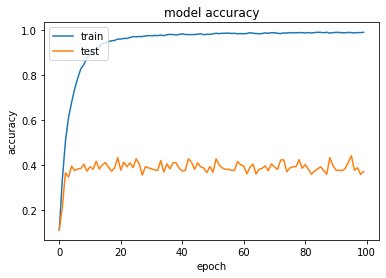

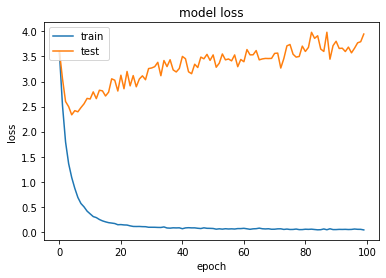

In [36]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

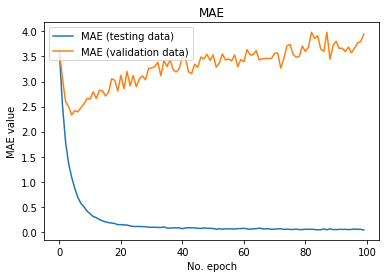

In [37]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

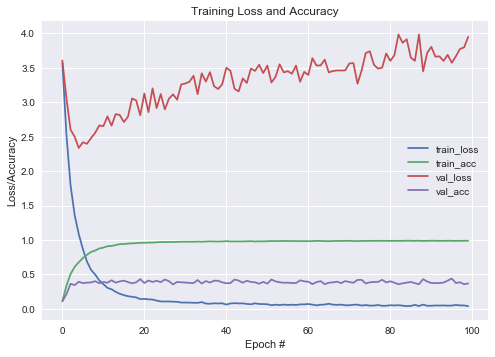

In [38]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()